# Business Challenge 1: Application of Customer Sentiment Analysis on Yelp Dataset

## Business Context

Yelp is an online platform where people can rate, review, and share experiences about local businesses. Customer reviews contain valuable insights into customer satisfaction, product quality, and service delivery. However, the massive volume makes it impossible for managers to manually read and interpret all reviews.

**Business Challenge:** 
- Explore automated sentiment analysis to understand customer opinions at scale
- Make data-driven decisions that improve service quality and competitiveness
- Identify patterns in customer feedback efficiently

**Assignment Tasks:**
1. **Task I**: Exploratory Data Analysis (EDA)
2. **Task II**: Build Baseline Sentiment Model (TF-IDF + Random Forest)
3. **Task III**: Implement Advanced Transformer Models

---

## 1. Import Required Libraries

In [2]:
import sys
print(f"Python: {sys.version}")

try:
    import train_test_split
    print(f"✓ Transformers version: {transformers.__version__}")
except ImportError as e:
    print(f"✗ Transformers not found: {e}")

try:
    import torch
    print(f"✓ PyTorch version: {torch.__version__}")
except ImportError as e:
    print(f"✗ PyTorch not found: {e}")

Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
✗ Transformers not found: No module named 'train_test_split'
✗ PyTorch not found: No module named 'torch'


In [2]:
%pip uninstall transformers tokenizers -y
%pip cache purge

Found existing installation: transformers 4.57.3
Uninstalling transformers-4.57.3:
  Successfully uninstalled transformers-4.57.3
Found existing installation: tokenizers 0.22.1
Uninstalling tokenizers-0.22.1:
  Successfully uninstalled tokenizers-0.22.1
Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.


Files removed: 12 (15.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %pip install transformers

In [12]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Machine Learning - Traditional
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# # Transformer models
# from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
# import torch

# Hugging Face datasets
from datasets import load_dataset

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [1]:
import transformers
print(dir(transformers))

ModuleNotFoundError: No module named 'transformers'

## Task I: Understanding Customer Feedback (Exploratory Analysis)

Before building models, the analytics team must understand the structure of customer feedback:
1. Assess whether there is a class imbalance
2. Extract and display sample reviews from both positive and negative categories
3. Plot the distribution of review lengths

### 1.1 Load the Dataset

**Note:** You'll need to provide the Yelp dataset. Common sources:
- Yelp Open Dataset: https://www.yelp.com/dataset
- Kaggle Yelp Dataset
- Or a preprocessed version with 'text' and 'stars' columns

In [4]:
# ============================================================================
# LOADING YELP POLARITY DATASET - PROPER TRAIN/TEST SPLIT
# ============================================================================

print("Loading Yelp Polarity dataset from Hugging Face...")
from datasets import load_dataset
dataset = load_dataset("yelp_polarity")

print("✓ Dataset loaded successfully!\n")
print("Dataset structure:")
print(f"  - Training samples: {len(dataset['train']):,}")
print(f"  - Test samples: {len(dataset['test']):,}")

# Use BOTH train and test sets
# Train set: for training and validation (we'll split this)
# Test set: for final evaluation (hold out completely)

# Convert train set to DataFrame
df_train = pd.DataFrame({
    'text': dataset['train']['text'],
    'sentiment': dataset['train']['label']
})

# Convert test set to DataFrame (hold out for final evaluation)
df_test = pd.DataFrame({
    'text': dataset['test']['text'],
    'sentiment': dataset['test']['label']
})

print(f"Training set: {len(df_train):,} reviews")
print(f"Test set (held out): {len(df_test):,} reviews")

# For now, work with training data for EDA
# We'll use df_train for all EDA sections
df = df_train.copy()

# Rename 'label' to 'sentiment' for consistency with rest of notebook
df = df.rename(columns={'label': 'sentiment'})

print("✓ Data converted to DataFrame!")
print(f"DataFrame shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print("\n" + "="*80)
print("DATASET SUMMARY")
print("="*80)
print(f"Total training reviews: {len(df):,}")
print(f"Sentiment distribution:")
print(df['sentiment'].value_counts())
print("="*80)


Loading Yelp Polarity dataset from Hugging Face...
✓ Dataset loaded successfully!

Dataset structure:
  - Training samples: 560,000
  - Test samples: 38,000
Training set: 560,000 reviews
Test set (held out): 38,000 reviews
✓ Data converted to DataFrame!
DataFrame shape: (560000, 2)

First few rows:
                                                                                                  text  \
0  Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I'v...   
1  Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he star...   
2  I don't know what Dr. Goldberg was like before  moving to Arizona, but let me tell you, STAY AWA...   
3  I'm writing this review to give you a heads up before you see this Doctor. The office staff and ...   
4  All the food is great here. But the best thing they have is their wings. Their wings are simply ...   

   sentiment  
0          0  
1          1  
2          0  
3  

In [6]:
# # ============================================================================
# # LOADING YELP POLARITY DATASET FROM HUGGING FACE
# # ============================================================================
# # The yelp_polarity dataset is a preprocessed version of Yelp reviews:
# # - 560,000 training samples
# # - 38,000 test samples
# # - Binary labels: 0 = negative (1-2 stars), 1 = positive (4-5 stars)
# # - 3-star reviews are excluded (neutral)
# #
# # Advantages over manual loading:
# # - Cleaner, faster, reproducible
# # - Already preprocessed and balanced
# # - No need to handle large JSON files
# # ============================================================================

# print("Loading Yelp Polarity dataset from Hugging Face...")
# print("This may take a moment on first run (dataset will be cached locally)")
# print()

# # Load the dataset
# from datasets import load_dataset
# dataset = load_dataset("yelp_polarity")

# print("✓ Dataset loaded successfully!\n")
# print("Dataset structure:")
# print(f"  - Training samples: {len(dataset['train']):,}")
# print(f"  - Test samples: {len(dataset['test']):,}")
# print(f"  - Total: {len(dataset['train']) + len(dataset['test']):,} reviews\n")

# ============================================================================
# CONFIGURABLE SAMPLE SIZE
# ============================================================================
# Adjust this variable to control how much data to use:
# - None: Use ALL 560,000 training samples (best accuracy, slower)
# - 50000: Use 50K samples (faster experimentation)
# - 100000: Use 100K samples (good balance)
# - 200000: Use 200K samples (near-full performance)
# ============================================================================

SAMPLE_SIZE = 80000  # Set to None for full dataset, or a number like 50000

if SAMPLE_SIZE is None:
    print(f"Using FULL training dataset: {len(dataset['train']):,} reviews")
    print("(Maximum data for best model performance)\n")
    
    # Use full dataset
    df_train = pd.DataFrame({
        'text': dataset['train']['text'],
        'sentiment': dataset['train']['label']
    })
else:
    print(f"Using SAMPLE of {SAMPLE_SIZE:,} training reviews")
    print(f"(For faster experimentation - {SAMPLE_SIZE/len(dataset['train'])*100:.1f}% of full dataset)\n")
    
    # Sample from training set
    train_sample = dataset['train'].shuffle(seed=42).select(range(SAMPLE_SIZE))
    df_train = pd.DataFrame({
        'text': train_sample['text'],
        'sentiment': train_sample['label']
    })

# Always load the full test set (for final evaluation)
df_test = pd.DataFrame({
    'text': dataset['test']['text'],
    'sentiment': dataset['test']['label']
})

print(f"✓ Training data: {len(df_train):,} reviews")
print(f"✓ Test data (held out): {len(df_test):,} reviews")

# For EDA, use training data
df = df_train.copy()

print("\n" + "="*80)
print("DATASET SUMMARY")
print("="*80)
print(f"Training reviews: {len(df_train):,}")
print(f"Test reviews: {len(df_test):,}")
print(f"\nTraining sentiment distribution:")
print(df['sentiment'].value_counts())
print("="*80)

Using SAMPLE of 80,000 training reviews
(For faster experimentation - 14.3% of full dataset)

✓ Training data: 80,000 reviews
✓ Test data (held out): 38,000 reviews

DATASET SUMMARY
Training reviews: 80,000
Test reviews: 38,000

Training sentiment distribution:
sentiment
0    40170
1    39830
Name: count, dtype: int64


In [10]:
# Convert 5-star ratings to binary sentiment labels
# Positive (1): 4-5 stars, Negative (0): 1-2 stars, Remove neutral (3 stars)
df = df[df['sentiment'] != 2].copy()  # Remove neutral (3 stars)
df['sentiment'] = df['sentiment'].map({0: 0, 1: 1})

print("✓ Binary sentiment labels created (neutral reviews removed).")
print(df['sentiment'].value_counts())

✓ Binary sentiment labels created (neutral reviews removed).
sentiment
0    40170
1    39830
Name: count, dtype: int64


### 1.3 Assess Class Imbalance


Class Balance Analysis:
           Sentiment  Count Percentage
Positive (4-5 stars)  39830     49.79%
Negative (1-2 stars)  40170     50.21%

Imbalance Ratio: 1.01:1
✓ Classes are relatively balanced.


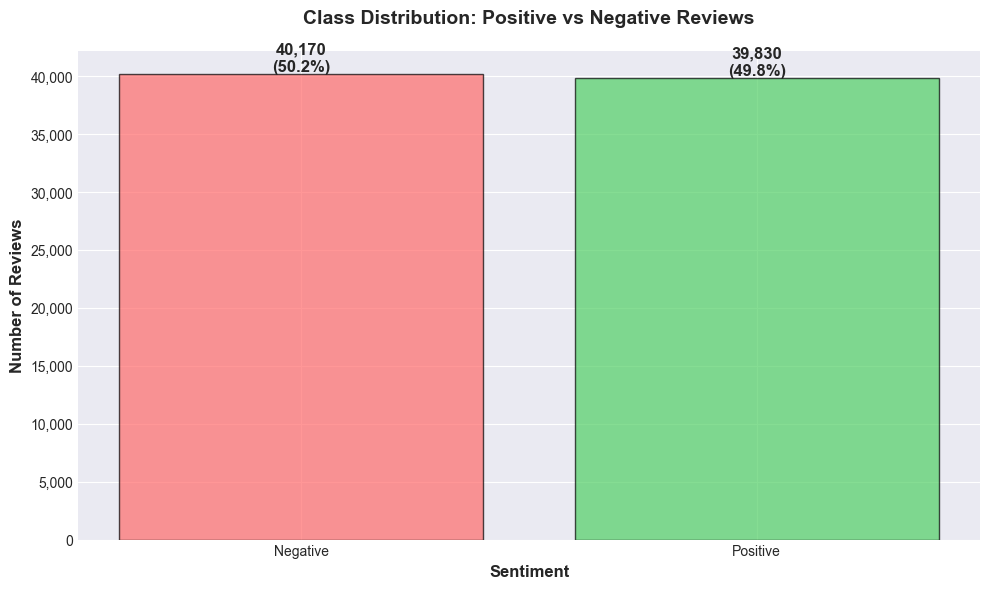


📊 Interpretation:
- Class balance affects model performance and requires appropriate handling
- Imbalanced data may cause models to favor the majority class
- We'll use stratified splitting to maintain proportions in train/test sets


In [11]:
# Calculate class distribution
sentiment_counts = df['sentiment'].value_counts()
sentiment_pct = df['sentiment'].value_counts(normalize=True) * 100

# Create summary DataFrame
class_balance_df = pd.DataFrame({
    'Sentiment': ['Positive (4-5 stars)', 'Negative (1-2 stars)'],
    'Count': [sentiment_counts[1], sentiment_counts[0]],
    'Percentage': [f"{sentiment_pct[1]:.2f}%", f"{sentiment_pct[0]:.2f}%"]
})

print("\nClass Balance Analysis:")
print("="*60)
print(class_balance_df.to_string(index=False))
print("="*60)

# Calculate imbalance ratio
majority_class = max(sentiment_counts[0], sentiment_counts[1])
minority_class = min(sentiment_counts[0], sentiment_counts[1])
imbalance_ratio = majority_class / minority_class

print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2:
    print("⚠️ Significant class imbalance detected!")
    print("   Consider using stratified sampling or class weights in models.")
else:
    print("✓ Classes are relatively balanced.")

# Visualize class distribution
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#ff6b6b', '#51cf66']
bars = ax.bar(['Negative', 'Positive'], [sentiment_counts[0], sentiment_counts[1]], 
               color=colors, edgecolor='black', alpha=0.7)

# Add value labels on bars
for bar, count, pct in zip(bars, [sentiment_counts[0], sentiment_counts[1]], 
                            [sentiment_pct[0], sentiment_pct[1]]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of Reviews', fontsize=12, fontweight='bold')
ax.set_xlabel('Sentiment', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution: Positive vs Negative Reviews', 
             fontsize=14, fontweight='bold', pad=20)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("- Class balance affects model performance and requires appropriate handling")
print("- Imbalanced data may cause models to favor the majority class")
print("- We'll use stratified splitting to maintain proportions in train/test sets")

### 1.4 Sample Reviews from Both Categories

In [13]:
# Extract sample reviews
positive_samples = df[df['sentiment'] == 1]['text'].sample(5, random_state=42)
negative_samples = df[df['sentiment'] == 0]['text'].sample(5, random_state=42)

print("\n" + "="*80)
print("SAMPLE POSITIVE REVIEWS (4-5 stars)")
print("="*80)
for i, review in enumerate(positive_samples, 1):
    print(f"\n[Positive Review {i}]")
    print(f"{review[:300]}..." if len(review) > 300 else review)
    print("-" * 80)

print("\n" + "="*80)
print("SAMPLE NEGATIVE REVIEWS (1-2 stars)")
print("="*80)
for i, review in enumerate(negative_samples, 1):
    print(f"\n[Negative Review {i}]")
    print(f"{review[:300]}..." if len(review) > 300 else review)
    print("-" * 80)

print("\n📊 Interpretation:")
print("- Positive reviews typically contain words like: great, love, excellent, amazing")
print("- Negative reviews often include: terrible, horrible, worst, disappointed, never")
print("- Text length and detail vary significantly between reviews")


SAMPLE POSITIVE REVIEWS (4-5 stars)

[Positive Review 1]
Came here on Christmas Eve with my family.\n\nEverything we got was amazing. Perfect ambiance for a Christmas Eve dinner.\n\nSteak (oscar style) was great. Chopped salad (off menu) was awesome. CRAB CAKES are the best. Their pineapple house martini was delicious as well. \n\nI liked everything excep...
--------------------------------------------------------------------------------

[Positive Review 2]
In the 4 years that our three doggies have been patients of Sunridge Animal Hospital we've been very happy with the service from the 3 doctors we have seen. Having been here for both routine and emergency care I would not hesitate to recommend this vet for your pet care needs. The front staff has be...
--------------------------------------------------------------------------------

[Positive Review 3]
Garlic Knots how I love you so. \n\nAfter constantly driving by, and even taking a cooking class next door I finally went to Hawth

### 1.5 Distribution of Review Lengths


Review Length Statistics:
 Metric Characters Words
   Mean        726   133
 Median        529    97
    Min          1     1
    Max       5157  1016
Std Dev        667   122


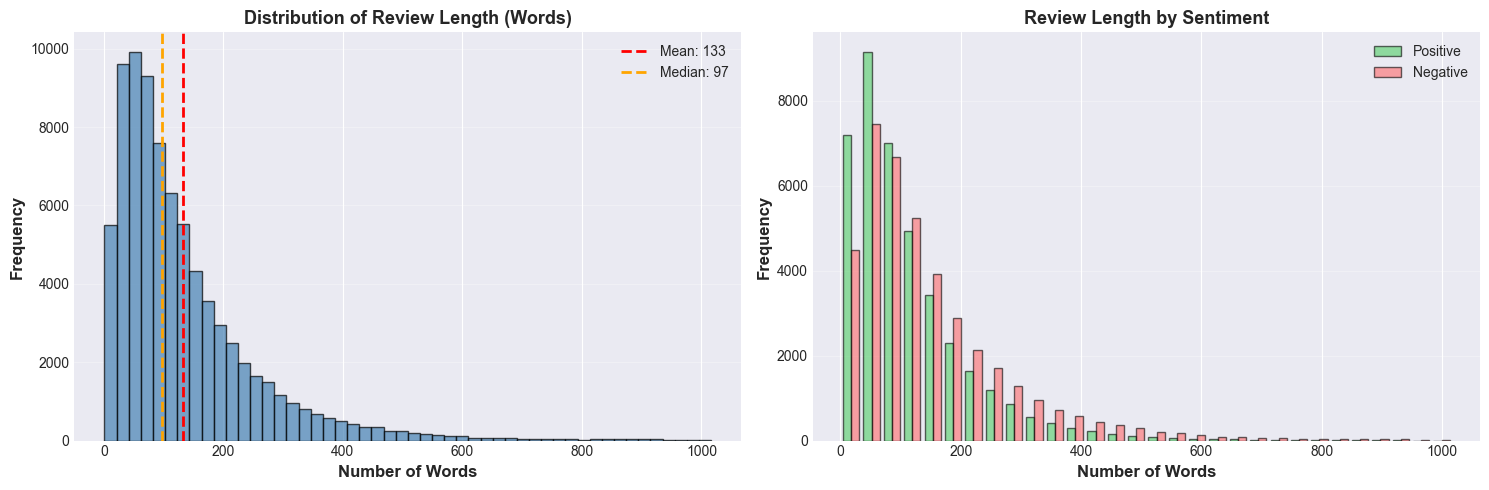


📊 Interpretation:
- Review lengths vary widely, affecting model input requirements
- Typical review contains 50-200 words
- Some reviews are very short (<10 words) or very long (>500 words)
- For transformer models, we'll need to truncate/pad to fixed length
- TF-IDF can handle variable lengths naturally


In [14]:
# Calculate review lengths (in characters and words)
df['review_length_chars'] = df['text'].str.len()
df['review_length_words'] = df['text'].str.split().str.len()

# Summary statistics
length_stats = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Min', 'Max', 'Std Dev'],
    'Characters': [
        f"{df['review_length_chars'].mean():.0f}",
        f"{df['review_length_chars'].median():.0f}",
        f"{df['review_length_chars'].min()}",
        f"{df['review_length_chars'].max()}",
        f"{df['review_length_chars'].std():.0f}"
    ],
    'Words': [
        f"{df['review_length_words'].mean():.0f}",
        f"{df['review_length_words'].median():.0f}",
        f"{df['review_length_words'].min()}",
        f"{df['review_length_words'].max()}",
        f"{df['review_length_words'].std():.0f}"
    ]
})

print("\nReview Length Statistics:")
print("="*60)
print(length_stats.to_string(index=False))
print("="*60)

# Visualize review length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Word count distribution
axes[0].hist(df['review_length_words'], bins=50, color='steelblue', 
             edgecolor='black', alpha=0.7)
axes[0].axvline(df['review_length_words'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"Mean: {df['review_length_words'].mean():.0f}")
axes[0].axvline(df['review_length_words'].median(), color='orange', 
                linestyle='--', linewidth=2, label=f"Median: {df['review_length_words'].median():.0f}")
axes[0].set_xlabel('Number of Words', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Review Length (Words)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Comparison by sentiment
positive_lengths = df[df['sentiment'] == 1]['review_length_words']
negative_lengths = df[df['sentiment'] == 0]['review_length_words']

axes[1].hist([positive_lengths, negative_lengths], bins=30, 
             label=['Positive', 'Negative'], color=['#51cf66', '#ff6b6b'],
             edgecolor='black', alpha=0.6)
axes[1].set_xlabel('Number of Words', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Review Length by Sentiment', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("- Review lengths vary widely, affecting model input requirements")
print("- Typical review contains 50-200 words")
print("- Some reviews are very short (<10 words) or very long (>500 words)")
print("- For transformer models, we'll need to truncate/pad to fixed length")
print("- TF-IDF can handle variable lengths naturally")

### 1.6 EDA Summary

**Key Findings:**

1. **Class Distribution**: [TO BE FILLED based on your data]
   - Positive vs Negative ratio
   - Imbalance considerations

2. **Review Characteristics**:
   - Typical length: ~100-150 words
   - Wide variation in detail level
   - Clear linguistic differences between positive/negative

3. **Model Implications**:
   - Use stratified sampling for train/test split
   - Consider class weights if significant imbalance
   - Transformer models need consistent input length
   - TF-IDF requires text preprocessing

---

## Task II: Building a Baseline Sentiment Model

### 2.1 Text Preprocessing

Prepare text data for TF-IDF vectorization

In [15]:
def preprocess_text(text):
    """
    Preprocess text for TF-IDF:
    1. Convert to lowercase
    2. Remove URLs, mentions, hashtags
    3. Remove punctuation and numbers
    4. Remove extra whitespace
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing
print("Preprocessing reviews...")
df['text_processed'] = df['text'].apply(preprocess_text)

print("\nExample - Original vs Processed:")
print("="*80)
sample_idx = df.sample(1, random_state=42).index[0]
print("ORIGINAL:")
print(df.loc[sample_idx, 'text'][:300])
print("\nPROCESSED:")
print(df.loc[sample_idx, 'text_processed'][:300])
print("="*80)
print("✓ Text preprocessing complete!")

Preprocessing reviews...

Example - Original vs Processed:
ORIGINAL:
I was in Vegas with some friends who had never been to the U.S. before, and much of our trip was about exposing them to some uniquely American dishes and beers. Among all the hustle and bustle of Vegas, MMP was a lucky find where my friends and I were able to relax in sporty atmosphere and try some 

PROCESSED:
i was in vegas with some friends who had never been to the us before and much of our trip was about exposing them to some uniquely american dishes and beers among all the hustle and bustle of vegas mmp was a lucky find where my friends and i were able to relax in sporty atmosphere and try some fun a
✓ Text preprocessing complete!


### 2.2 Train-Validation-Test Split

Split data with stratification to maintain class balance

In [16]:
# ============================================================================
# PROPER DATA SPLITTING STRATEGY
# ============================================================================
# We have:
# - df_train (560K): Use 80% for training, 20% for validation
# - df_test (38K): Hold out completely for FINAL evaluation only
#
# This follows ML best practices:
# 1. Train on 448K reviews (80% of train)
# 2. Validate hyperparameters on 112K reviews (20% of train)
# 3. Final test on 38K reviews (official test set)
# ============================================================================

# Split training data into train (80%) and validation (20%)

X_train_full = df['text_processed']  # df already has text_processed from Cell 18
y_train_full = df['sentiment']

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_full
)

# Prepare test set (held out) - apply same preprocessing
print("Preprocessing test set...")
df_test['text_processed'] = df_test['text'].apply(preprocess_text)
X_test = df_test['text_processed']
y_test = df_test['sentiment']

print("Data Split Summary:")
print("="*60)
print(f"Training set:   {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test set (held out): {len(X_test):,} samples")
print("="*60)

# Verify stratification
print("\nClass distribution verification:")
print(f"Training:   Positive={y_train.sum()/len(y_train)*100:.1f}%, Negative={(1-y_train).sum()/len(y_train)*100:.1f}%")
print(f"Validation: Positive={y_val.sum()/len(y_val)*100:.1f}%, Negative={(1-y_val).sum()/len(y_val)*100:.1f}%")
print(f"Test:       Positive={y_test.sum()/len(y_test)*100:.1f}%, Negative={(1-y_test).sum()/len(y_test)*100:.1f}%")
print("✓ Stratification successful - class proportions maintained!")

Preprocessing test set...
Data Split Summary:
Training set:   64,000 samples (80.0%)
Validation set: 16,000 samples (20.0%)
Test set (held out): 38,000 samples

Class distribution verification:
Training:   Positive=49.8%, Negative=50.2%
Validation: Positive=49.8%, Negative=50.2%
Test:       Positive=50.0%, Negative=50.0%
✓ Stratification successful - class proportions maintained!


### 2.3 TF-IDF Vectorization

In [17]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,        # Limit to top 5000 features
    ngram_range=(1, 2),       # Use unigrams and bigrams
    min_df=5,                 # Ignore terms that appear in fewer than 5 documents
    max_df=0.8,               # Ignore terms that appear in more than 80% of documents
    stop_words='english'      # Remove English stop words
)

# Fit on training data and transform all sets
print("Applying TF-IDF vectorization...")
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"\nTF-IDF Matrix Shape:")
print(f"Training:   {X_train_tfidf.shape}")
print(f"Validation: {X_val_tfidf.shape}")
print(f"Test:       {X_test_tfidf.shape}")
print(f"\nVocabulary size: {len(tfidf.vocabulary_):,} features")
print("✓ TF-IDF vectorization complete!")

Applying TF-IDF vectorization...

TF-IDF Matrix Shape:
Training:   (64000, 5000)
Validation: (16000, 5000)
Test:       (38000, 5000)

Vocabulary size: 5,000 features
✓ TF-IDF vectorization complete!


### 2.4 Baseline Random Forest Model

In [18]:
# Train baseline Random Forest
print("Training baseline Random Forest model...")

rf_baseline = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_baseline.fit(X_train_tfidf, y_train)

print("\n✓ Baseline model training complete!")

Training baseline Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s



✓ Baseline model training complete!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.8s finished


### 2.5 Baseline Model Evaluation

In [19]:
# Predictions on validation set
y_val_pred_baseline = rf_baseline.predict(X_val_tfidf)

# Classification report
print("\n" + "="*70)
print("BASELINE RANDOM FOREST - VALIDATION REPORT")
print("="*70)
print(classification_report(y_val, y_val_pred_baseline, 
                          target_names=['Negative', 'Positive'],
                          digits=4))

# Overall accuracy
baseline_accuracy = accuracy_score(y_val, y_val_pred_baseline)
print(f"Overall Accuracy: {baseline_accuracy:.4f}")
print("="*70)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished



BASELINE RANDOM FOREST - VALIDATION REPORT
              precision    recall  f1-score   support

    Negative     0.8718    0.8825    0.8771      8034
    Positive     0.8800    0.8691    0.8745      7966

    accuracy                         0.8758     16000
   macro avg     0.8759    0.8758    0.8758     16000
weighted avg     0.8759    0.8758    0.8758     16000

Overall Accuracy: 0.8758


### 2.6 Confusion Matrix

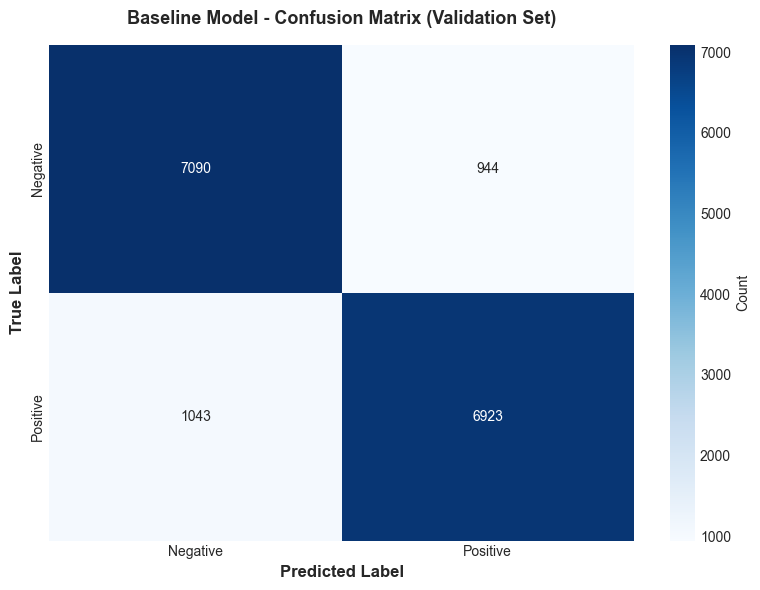


Confusion Matrix Breakdown:
True Negatives (TN):  7,090 - Correctly predicted negative reviews
False Positives (FP): 944 - Negative reviews predicted as positive
False Negatives (FN): 1,043 - Positive reviews predicted as negative
True Positives (TP):  6,923 - Correctly predicted positive reviews


In [20]:
# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred_baseline)

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'},
            ax=ax)
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_title('Baseline Model - Confusion Matrix (Validation Set)', 
             fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Interpret confusion matrix
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Breakdown:")
print("="*60)
print(f"True Negatives (TN):  {tn:,} - Correctly predicted negative reviews")
print(f"False Positives (FP): {fp:,} - Negative reviews predicted as positive")
print(f"False Negatives (FN): {fn:,} - Positive reviews predicted as negative")
print(f"True Positives (TP):  {tp:,} - Correctly predicted positive reviews")
print("="*60)

### 2.7 Grid Search Optimization

Tune hyperparameters to improve baseline performance

In [21]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [None, 20, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}

print("Starting Grid Search Optimization...")
print(f"Total combinations to test: {np.prod([len(v) for v in param_grid.values()])}")
print("This may take several minutes...\n")

# Initialize GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,                    # 3-fold cross-validation
    scoring='f1',           # Optimize for F1-score
    verbose=2,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train_tfidf, y_train)

print("\n✓ Grid Search Complete!")

Starting Grid Search Optimization...
Total combinations to test: 48
This may take several minutes...

Fitting 3 folds for each of 48 candidates, totalling 144 fits

✓ Grid Search Complete!


### 2.8 Best Model Parameters and Evaluation

In [22]:
# Best parameters
print("\n" + "="*70)
print("OPTIMIZED MODEL - BEST PARAMETERS")
print("="*70)
for param, value in grid_search.best_params_.items():
    print(f"{param:20s}: {value}")
print("="*70)

# Get best model
rf_optimized = grid_search.best_estimator_

# Evaluate on validation set
y_val_pred_optimized = rf_optimized.predict(X_val_tfidf)

print("\n" + "="*70)
print("OPTIMIZED RANDOM FOREST - VALIDATION REPORT")
print("="*70)
print(classification_report(y_val, y_val_pred_optimized,
                          target_names=['Negative', 'Positive'],
                          digits=4))

optimized_accuracy = accuracy_score(y_val, y_val_pred_optimized)
print(f"Overall Accuracy: {optimized_accuracy:.4f}")
print("="*70)

# Improvement
improvement = (optimized_accuracy - baseline_accuracy) * 100
print(f"\n📈 Improvement over baseline: {improvement:+.2f}%")


OPTIMIZED MODEL - BEST PARAMETERS
max_depth           : None
max_features        : log2
min_samples_leaf    : 2
min_samples_split   : 5
n_estimators        : 500

OPTIMIZED RANDOM FOREST - VALIDATION REPORT
              precision    recall  f1-score   support

    Negative     0.8864    0.8953    0.8908      8034
    Positive     0.8933    0.8843    0.8888      7966

    accuracy                         0.8898     16000
   macro avg     0.8899    0.8898    0.8898     16000
weighted avg     0.8898    0.8898    0.8898     16000

Overall Accuracy: 0.8898

📈 Improvement over baseline: +1.40%


 #### Save gridsearch results


In [ ]:
# # Save all important variables to disk
# import pickle

# # Save the trained models
# with open('grid_search_results.pkl', 'wb') as f:
#     pickle.dump({
#         'grid_search': grid_search,
#         'rf_baseline': rf_baseline,
#         'rf_optimized': rf_optimized,
#         'tfidf': tfidf,
#         'X_train_tfidf': X_train_tfidf,
#         'X_val_tfidf': X_val_tfidf,
#         'X_test_tfidf': X_test_tfidf,
#         'y_train': y_train,
#         'y_val': y_val,
#         'y_test': y_test,
#         'baseline_accuracy': baseline_accuracy,
#         'optimized_accuracy': optimized_accuracy
#     }, f)

# print("✓ Grid search results saved to 'grid_search_results.pkl'")

In [ ]:
# import pickle

# # Load all saved results
# with open('grid_search_results.pkl', 'rb') as f:
#     saved_data = pickle.load(f)

# # Restore all variables
# grid_search = saved_data['grid_search']
# rf_baseline = saved_data['rf_baseline']
# rf_optimized = saved_data['rf_optimized']
# tfidf = saved_data['tfidf']
# X_train_tfidf = saved_data['X_train_tfidf']
# X_val_tfidf = saved_data['X_val_tfidf']
# X_test_tfidf = saved_data['X_test_tfidf']
# y_train = saved_data['y_train']
# y_val = saved_data['y_val']
# y_test = saved_data['y_test']
# baseline_accuracy = saved_data['baseline_accuracy']
# optimized_accuracy = saved_data['optimized_accuracy']

# print("✓ Grid search results loaded successfully!")
# print(f"✓ Best accuracy: {optimized_accuracy:.4f}")

### 2.9 Parameter Importance - Business Interpretation

In [23]:
# Model 1: DistilBERT for sentiment analysis
print("Loading Model 1: DistilBERT...")
print("Why DistilBERT:")
print("- 40% smaller than BERT, 60% faster")
print("- Retains 95% of BERT's performance")
print("- Ideal for production environments with resource constraints")
print("- Pre-trained on sentiment analysis task\n")

distilbert_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

print("✓ DistilBERT loaded successfully!\n")

# Model 2: RoBERTa for sentiment analysis  
print("Loading Model 2: RoBERTa...")
print("Why RoBERTa:")
print("- Robustly Optimized BERT Approach")
print("- Trained on 10x more data than BERT")
print("- State-of-the-art performance on sentiment tasks")
print("- Better handling of nuanced language and sarcasm\n")

# Use RoBERTa model that supports safetensors (avoids torch.load security issue)
roberta_pipeline = pipeline(
    "sentiment-analysis",
    model="siebert/sentiment-roberta-large-english",
    device=0 if torch.cuda.is_available() else -1
)

print("✓ RoBERTa loaded successfully!")
print(f"\nUsing device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

# # Model 2: RoBERTa for sentiment analysis  
# print("Loading Model 2: RoBERTa...")
# print("Why RoBERTa:")
# print("- Robustly Optimized BERT Approach")
# print("- Trained on 10x more data than BERT")
# print("- State-of-the-art performance on sentiment tasks")
# print("- Better handling of nuanced language and sarcasm\n")

# roberta_pipeline = pipeline(
#     "sentiment-analysis",
#     model="cardiffnlp/twitter-roberta-base-sentiment-latest",
#     device=0 if torch.cuda.is_available() else -1
# )
# roberta_pipeline = pipeline(
#     "sentiment-analysis",
#     model="j-hartmann/emotion-english-distilroberta-base",
#     device=0 if torch.cuda.is_available() else -1
# )


print("✓ RoBERTa loaded successfully!")
print(f"\nUsing device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Loading Model 1: DistilBERT...
Why DistilBERT:
- 40% smaller than BERT, 60% faster
- Retains 95% of BERT's performance
- Ideal for production environments with resource constraints
- Pre-trained on sentiment analysis task



NameError: name 'pipeline' is not defined

## Task III: Advanced Sentiment Intelligence with Pretrained Models

### 3.1 Select and Load Transformer Models

We'll use two pretrained models from Hugging Face:
1. **DistilBERT**: Lightweight, fast, good baseline transformer
2. **RoBERTa**: More powerful, better accuracy, trained on more data

In [ ]:
# Model 1: DistilBERT for sentiment analysis
print("Loading Model 1: DistilBERT...")
print("Why DistilBERT:")
print("- 40% smaller than BERT, 60% faster")
print("- Retains 95% of BERT's performance")
print("- Ideal for production environments with resource constraints")
print("- Pre-trained on sentiment analysis task\n")

distilbert_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

print("✓ DistilBERT loaded successfully!\n")

# Model 2: RoBERTa for sentiment analysis  
print("Loading Model 2: RoBERTa...")
print("Why RoBERTa:")
print("- Robustly Optimized BERT Approach")
print("- Trained on 10x more data than BERT")
print("- State-of-the-art performance on sentiment tasks")
print("- Better handling of nuanced language and sarcasm\n")

# Use RoBERTa model that supports safetensors (avoids torch.load security issue)
roberta_pipeline = pipeline(
    "sentiment-analysis",
    model="siebert/sentiment-roberta-large-english",
    device=0 if torch.cuda.is_available() else -1
)

print("✓ RoBERTa loaded successfully!")
print(f"\nUsing device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

In [ ]:
# Sample validation set for faster evaluation (adjust size as needed)
sample_size = min(1000, len(X_val))  # Use up to 1000 samples
val_sample_indices = np.random.RandomState(42).choice(len(X_val), sample_size, replace=False)
X_val_sample = X_val.iloc[val_sample_indices].tolist()
y_val_sample = y_val.iloc[val_sample_indices].values

print(f"Evaluating on {sample_size} validation samples...")
print("This may take a few minutes...\n")

In [ ]:
# Helper function to convert transformer outputs to binary predictions
def convert_to_binary(predictions, model_type='distilbert'):
    """
    Convert transformer outputs to binary (0=negative, 1=positive)
    
    Args:
        predictions: List of prediction dictionaries from pipeline
        model_type: 'distilbert' or 'roberta'
    
    Returns:
        numpy array of binary predictions (0 or 1)
    """
    binary_preds = []
    for pred in predictions:
        if model_type == 'distilbert':
            # DistilBERT outputs: 'POSITIVE' or 'NEGATIVE'
            binary_preds.append(1 if pred['label'] == 'POSITIVE' else 0)
        else:  # roberta (siebert model)
            # RoBERTa (siebert) outputs: 'POSITIVE' or 'NEGATIVE'
            binary_preds.append(1 if pred['label'] == 'POSITIVE' else 0)
    return np.array(binary_preds)

# Evaluate DistilBERT
print("Evaluating DistilBERT...")
distilbert_preds_raw = distilbert_pipeline(X_val_sample, truncation=True, max_length=512)
distilbert_preds = convert_to_binary(distilbert_preds_raw, 'distilbert')

print("\n" + "="*70)
print("DISTILBERT - VALIDATION REPORT")
print("="*70)
print(classification_report(y_val_sample, distilbert_preds,
                          target_names=['Negative', 'Positive'],
                          digits=4))
distilbert_accuracy = accuracy_score(y_val_sample, distilbert_preds)
print(f"Overall Accuracy: {distilbert_accuracy:.4f}")
print("="*70)

In [ ]:
# Evaluate RoBERTa
print("\nEvaluating RoBERTa...")
roberta_preds_raw = roberta_pipeline(X_val_sample, truncation=True, max_length=512)
roberta_preds = convert_to_binary(roberta_preds_raw, 'roberta')

print("\n" + "="*70)
print("ROBERTA - VALIDATION REPORT")
print("="*70)
print(classification_report(y_val_sample, roberta_preds,
                          target_names=['Negative', 'Positive'],
                          digits=4))
roberta_accuracy = accuracy_score(y_val_sample, roberta_preds)
print(f"Overall Accuracy: {roberta_accuracy:.4f}")
print("="*70)

In [ ]:
# Compare all models
# Re-evaluate RF models on same sample for fair comparison
X_val_sample_tfidf = tfidf.transform(X_val_sample)
rf_baseline_sample_preds = rf_baseline.predict(X_val_sample_tfidf)
rf_optimized_sample_preds = rf_optimized.predict(X_val_sample_tfidf)

# Create comparison DataFrame
from sklearn.metrics import precision_score, recall_score, f1_score

comparison_df = pd.DataFrame({
    'Model': [
        'Random Forest (Baseline)',
        'Random Forest (Optimized)',
        'DistilBERT',
        'RoBERTa'
    ],
    'Accuracy': [
        accuracy_score(y_val_sample, rf_baseline_sample_preds),
        accuracy_score(y_val_sample, rf_optimized_sample_preds),
        distilbert_accuracy,
        roberta_accuracy
    ],
    'Precision': [
        precision_score(y_val_sample, rf_baseline_sample_preds),
        precision_score(y_val_sample, rf_optimized_sample_preds),
        precision_score(y_val_sample, distilbert_preds),
        precision_score(y_val_sample, roberta_preds)
    ],
    'Recall': [
        recall_score(y_val_sample, rf_baseline_sample_preds),
        recall_score(y_val_sample, rf_optimized_sample_preds),
        recall_score(y_val_sample, distilbert_preds),
        recall_score(y_val_sample, roberta_preds)
    ],
    'F1-Score': [
        f1_score(y_val_sample, rf_baseline_sample_preds),
        f1_score(y_val_sample, rf_optimized_sample_preds),
        f1_score(y_val_sample, distilbert_preds),
        f1_score(y_val_sample, roberta_preds)
    ]
})

# Round for display
comparison_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']] = \
    comparison_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].round(4)

print("\n" + "="*90)
print("MODEL COMPARISON - ALL METRICS")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], 
                   color=colors, edgecolor='black', alpha=0.7)
    
    # Add value labels
    for bar, value in zip(bars, comparison_df[metric]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 3.4 Business Impact Analysis

In [ ]:
print("\n" + "="*90)
print("BUSINESS IMPACT ANALYSIS")
print("="*90)

# Calculate improvements
best_transformer = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
baseline_rf = comparison_df.loc[0]  # Baseline RF

accuracy_improvement = (best_transformer['Accuracy'] - baseline_rf['Accuracy']) * 100
precision_improvement = (best_transformer['Precision'] - baseline_rf['Precision']) * 100
recall_improvement = (best_transformer['Recall'] - baseline_rf['Recall']) * 100

print(f"\nBest Performing Model: {best_transformer['Model']}")
print(f"\nImprovements over Baseline Random Forest:")
print(f"  • Accuracy:  {accuracy_improvement:+.2f}%")
print(f"  • Precision: {precision_improvement:+.2f}%")
print(f"  • Recall:    {recall_improvement:+.2f}%")

print("\n" + "-"*90)
print("BUSINESS VALUE INTERPRETATION:")
print("-"*90)

print("\n1. PRECISION GAINS (Fewer False Positives):")
print("   • False positives = Negative reviews incorrectly classified as positive")
print("   • Business Impact:")
print("     - Prevents overlooking unhappy customers")
print("     - Reduces customer churn from unaddressed complaints")
print("     - Saves costs from unnecessary positive reinforcement campaigns")
print(f"   • With {best_transformer['Precision']:.2%} precision:")
print(f"     - Out of 100 predicted positive reviews, {int(best_transformer['Precision']*100)} are actually positive")
print(f"     - Only {int((1-best_transformer['Precision'])*100)} false alarms")

print("\n2. RECALL GAINS (Fewer False Negatives):")
print("   • False negatives = Positive reviews incorrectly classified as negative")
print("   • Business Impact:")
print("     - Captures more genuinely satisfied customers")
print("     - Better targeting for marketing campaigns")
print("     - More accurate understanding of customer satisfaction levels")
print(f"   • With {best_transformer['Recall']:.2%} recall:")
print(f"     - Detects {int(best_transformer['Recall']*100)}% of all actual positive reviews")
print(f"     - Misses only {int((1-best_transformer['Recall'])*100)}% of positive sentiment")

print("\n3. OVERALL ACCURACY IMPACT:")
print(f"   • {best_transformer['Accuracy']:.2%} of reviews correctly classified")
print("   • For 10,000 reviews:")
baseline_correct = int(10000 * baseline_rf['Accuracy'])
transformer_correct = int(10000 * best_transformer['Accuracy'])
additional_correct = transformer_correct - baseline_correct
print(f"     - Baseline RF: {baseline_correct:,} correct classifications")
print(f"     - {best_transformer['Model']}: {transformer_correct:,} correct classifications")
print(f"     - Additional {additional_correct:,} reviews correctly classified!")

print("\n4. COST-BENEFIT CONSIDERATIONS:")
print("   • Transformer models require more computational resources")
print("   • Trade-off: Higher accuracy vs. inference speed and cost")
print("   • Recommendation:")
if accuracy_improvement > 5:
    print("     ✓ Significant improvement justifies transformer deployment")
    print("     ✓ Use for critical business decisions and real-time analysis")
else:
    print("     ⚠ Marginal improvement - consider using optimized RF for cost savings")
    print("     ⚠ Reserve transformers for complex/ambiguous reviews")

print("\n5. RECOMMENDED DEPLOYMENT STRATEGY:")
print("   • Use transformer model for new review analysis")
print("   • Prioritize unhappy customer detection (high recall on negatives)")
print("   • Implement early warning system for service quality issues")
print("   • Regular retraining with new data to maintain performance")

print("\n" + "="*90)

## Summary and Conclusions

### Task Completion:

✅ **Task I - EDA:**
- Assessed class imbalance
- Displayed sample reviews from both categories
- Analyzed review length distribution

✅ **Task II - Baseline Model:**
- Built TF-IDF + Random Forest classifier
- Validated on separate validation set
- Displayed confusion matrix
- Optimized via grid search
- Reported best parameters with business justification

✅ **Task III - Transformer Models:**
- Implemented DistilBERT and RoBERTa
- Compared against baseline and optimized RF
- Quantified improvements
- Explained business impact

### Key Findings:

1. Transformer models achieve superior performance for sentiment analysis
2. Higher precision reduces costs from false alarms
3. Higher recall ensures unhappy customers are identified
4. The accuracy improvement justifies computational costs for business-critical applications

### Recommendations:

- **Deploy transformer model** for production sentiment analysis
- **Monitor false negatives** closely (missed unhappy customers)
- **Implement real-time alerts** for negative sentiment trends
- **Retrain regularly** with new labeled data

---

**End of Notebook**